In [1]:
import numpy as np
from pymoo.model.problem import Problem
import pandas as pd

# Read data

In [2]:
datafile = "anonymized-data.csv"
df = pd.read_csv(datafile)
n_obs = df.shape[0]
df

,Your Full Name,Date Preference [Sun 20th Dec 2020],Date Preference [Sat 26th Dec 2020],Date Preference [Sun 3rd Jan 2021],Can you cook?,Course Choices,What will you NOT eat?,What will you drink?
0,Person 1,Med (1),High (2),Low (0),No,"Dessert (D), None (N)",All Meat (including birds),"Wine, Beer, Soft drinks"
1,Person 2,High (2),Low (0),Med (1),Yes,"Appetizer (A), Main (M)",NaN,"Wine, Beer, Cocktails, Soft drinks"
2,Person 3,High (2),Med (1),Low (0),Yes,"Appetizer (A), Main (M)","Offals/organs, please no..","Wine, Cocktails"
3,Person 4,Low (0),High (2),Med (1),Yes,Main (M),I can eat the food that a little spicy but not...,Soft drinks
4,Person 5,Med (1),High (2),Low (0),Yes,Appetizer (A),NaN,"Wine, Beer, Cocktails, Soft drinks"
5,Person 6,Med (1),Low (0),High (2),Yes,"Appetizer (A), Main (M), Dessert (D)",NaN,"Beer, Cocktails, Soft drinks"
6,Person 7,High (2),Med (1),Low (0),Yes,"Appetizer (A), Main (M)",NaN,"Wine, Beer, Cocktails, Soft drinks"


## Preprocess

In [3]:
import re
df = pd.read_csv(datafile)
# priority for date
df.iloc[:, 1:4] = df.iloc[:, 1:4].applymap(lambda x: int(re.search(r"\d", x).group(0)))

# yes-no to 0,1
df.iloc[:, 4] =  df.iloc[:, 4].eq("Yes").mul(1)

# course choice
df.iloc[:, 5] = df.iloc[:, 5].apply(lambda x: re.findall(r".(?=\))", x))

df

,Your Full Name,Date Preference [Sun 20th Dec 2020],Date Preference [Sat 26th Dec 2020],Date Preference [Sun 3rd Jan 2021],Can you cook?,Course Choices,What will you NOT eat?,What will you drink?
0,Person 1,1,2,0,0,"[D, N]",All Meat (including birds),"Wine, Beer, Soft drinks"
1,Person 2,2,0,1,1,"[A, M]",NaN,"Wine, Beer, Cocktails, Soft drinks"
2,Person 3,2,1,0,1,"[A, M]","Offals/organs, please no..","Wine, Cocktails"
3,Person 4,0,2,1,1,[M],I can eat the food that a little spicy but not...,Soft drinks
4,Person 5,1,2,0,1,[A],NaN,"Wine, Beer, Cocktails, Soft drinks"
5,Person 6,1,0,2,1,"[A, M, D]",NaN,"Beer, Cocktails, Soft drinks"
6,Person 7,2,1,0,1,"[A, M]",NaN,"Wine, Beer, Cocktails, Soft drinks"


# Define Problem
we will encode the index of the attendee in X

In [4]:
def list_contains(l, val):
    for l_ in l:
        if val in l_:
            return True
    return False

def num_courses(l):
    count = 0
    for c in ['A', 'M', 'D']:
        if list_contains(l, c):
            count += 1
    return count



def arr_to_dict(x):
    all_days = df.iloc[x,:]
    day1 = df.iloc[x[0:3],:].drop_duplicates(subset = "Your Full Name")
    day2 = df.iloc[x[3:6],:].drop_duplicates(subset = "Your Full Name")
    day3 = df.iloc[x[6:9],:].drop_duplicates(subset = "Your Full Name")
    
    res = {
        "day1":{},
        "day2":{},
        "day3":{},
        "all_days":{}
    }
    res["all_days"]["people"] = all_days.iloc[:, 0].unique()
    res["day1"]["people"] = day1.iloc[:, 0].unique()
    res["day2"]["people"] = day2.iloc[:, 0].unique()
    res["day3"]["people"] = day3.iloc[:, 0].unique()

    res["day1"]["pref"] = day1.iloc[:, 1].sum()
    res["day2"]["pref"] = day2.iloc[:, 2].sum()
    res["day3"]["pref"] = day3.iloc[:, 3].sum()

    res["day1"]["courses"] = day1.iloc[:, 5].tolist()
    res["day2"]["courses"] = day2.iloc[:, 5].tolist()
    res["day3"]["courses"] = day3.iloc[:, 5].tolist()

    # print(res["day3"]["courses"])

    res["day1"]["cd"] = num_courses(res["day1"]["courses"])
    res["day2"]["cd"] = num_courses(res["day2"]["courses"])
    res["day3"]["cd"] = num_courses(res["day3"]["courses"])

    return res

In [5]:
class ChristmasProblem(Problem):

    def __init__(self):
        super().__init__(
            n_var= 9,
            n_obj = 3,
            n_constr= 0,

            xl=np.zeros(9),
            xu=np.ones(9)*n_obs-1,
            elementwise_evaluation=True
        )
    
    def _evaluate(self, x, out, *args, **kwargs):
        # fitness
        prop = arr_to_dict(x)
        # print(prop["all_days"]["people"].shape)

        f = []

        # sample all + sample distinct in day
        f.append( - prop["all_days"]["people"].shape[0] - (prop["day1"]["people"].shape[0] + prop["day2"]["people"].shape[0] + prop["day3"]["people"].shape[0]))

        # preferred day
        f.append( - (prop["day1"]["pref"] + prop["day2"]["pref"] + prop["day3"]["pref"]))

        # course diversity
        f.append( - (prop["day1"]["cd"] + prop["day2"]["cd"] + prop["day3"]["cd"]))

        # constraints
        out["F"] = f
        out["G"] = []


vectorized_problem = ChristmasProblem()

 # Run EA

In [6]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=5,
    sampling=get_sampling("int_lhs"),
    crossover=get_crossover("int_sbx", prob=0.8, eta=15),
    mutation=get_mutation("int_pm", eta=20),
    eliminate_duplicates=True
)

# termination
termination = get_termination("n_gen", 200)

res = minimize(vectorized_problem,
               algorithm,
               termination,
               seed=4646,
               save_history=True,
               verbose=True)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       4 |            - |            -
    2 |     105 |       5 |  0.094280904 |            f
    3 |     110 |       6 |  0.00000E+00 |            f
    4 |     115 |       6 |  0.00000E+00 |            f
    5 |     120 |       6 |  0.250000000 |        ideal
    6 |     125 |       2 |  3.000000000 |        nadir
    7 |     130 |       2 |  0.00000E+00 |            f
    8 |     135 |       4 |  1.000000000 |        nadir
    9 |     140 |       4 |  0.00000E+00 |            f
   10 |     145 |       5 |  0.00000E+00 |            f
   11 |     150 |       5 |  0.00000E+00 |            f
   12 |     155 |       5 |  0.00000E+00 |            f
   13 |     160 |       5 |  0.00000E+00 |            f
   14 |     165 |       5 |  0.00000E+00 |            f
   15 |     170 |       5 |  0.00000E+00 |            f
   16 |     175 |       4 |  0.083333333 |            f
   17 |     180 |       5 |  0.00000E+00 |      

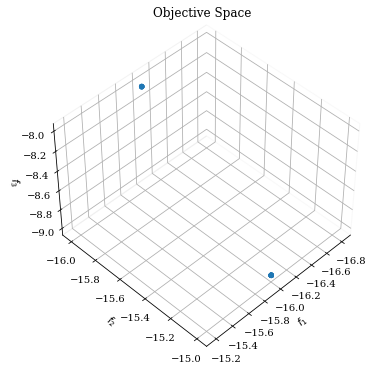

In [7]:
from pymoo.visualization.scatter import Scatter

pf = vectorized_problem.pareto_front()

# Objective Space
plot = Scatter(title = "Objective Space",)
plot.add(res.F)
if pf is not None:
    plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show()


In [8]:
n_evals = []    # corresponding number of function evaluations\
F = []          # the objective space values in each generation
cv = []         # constraint violation in each generation


# iterate over the deepcopies of algorithms
for algorithm in res.history:

    # store the number of function evaluations
    n_evals.append(algorithm.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algorithm.opt

    # store the least contraint violation in this generation
    cv.append(opt.get("CV").min())

    # filter out only the feasible and append
    feas = np.where(opt.get("feasible"))[0]
    _F = opt.get("F")[feas]
    F.append(_F)

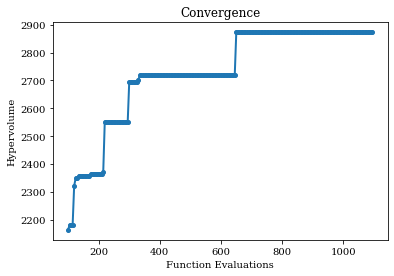

In [9]:
import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume

# MODIFY - this is problem dependend
ref_point = np.array([1.0, 1.0, 1.0])

# create the performance indicator object with reference point
metric = Hypervolume(ref_point=ref_point, normalize=False)

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in F]

# visualze the convergence curve
plt.plot(n_evals, hv, '-o', markersize=4, linewidth=2)
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

# Select Compromise Point

In [10]:
from pymoo.factory import get_problem, get_visualization, get_decomposition

weights = np.array([2, 3, 1])
decomp = get_decomposition("asf")
I = get_decomposition("asf").do(res.F, weights).argmin()

In [11]:
out = arr_to_dict(res.X[I])
out

{'day1': {'people': array(['Person 7', 'Person 3', 'Person 2'], dtype=object),
  'pref': 6,
  'courses': [['A', 'M'], ['A', 'M'], ['A', 'M']],
  'cd': 2},
 'day2': {'people': array(['Person 5', 'Person 1', 'Person 4'], dtype=object),
  'pref': 6,
  'courses': [['A'], ['D', 'N'], ['M']],
  'cd': 3},
 'day3': {'people': array(['Person 6', 'Person 2', 'Person 4'], dtype=object),
  'pref': 4,
  'courses': [['A', 'M', 'D'], ['A', 'M'], ['M']],
  'cd': 3},
 'all_days': {'people': array(['Person 7', 'Person 3', 'Person 2', 'Person 5', 'Person 1',
         'Person 4', 'Person 6'], dtype=object)}}